# Fine-tuning SpeechT5

Artık metinden sese görevine ve İngilizce veriler üzerinde önceden eğitilmiş SpeechT5 modelinin iç işleyişine aşina olduğunuza göre, başka bir dile nasıl ince ayar yapabileceğimizi görelim.

In [1]:
!pip install -q transformers datasets soundfile accelerate

In [2]:
!pip install -q speechbrain==0.5.16

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## The dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset(
    "facebook/voxpopuli", "nl", split="train", trust_remote_code=True
)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

In [5]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

## Preprocessing the data


In [6]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

### Text cleanup for SpeechT5 tokenization

In [7]:
tokenizer = processor.tokenizer

In [8]:
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

Veri kümesi örneklerinin raw_text ve normalized_text özelliklerini içerdiğini fark edebilirsiniz. Metin girişi olarak hangi özelliğin kullanılacağına karar verirken, SpeechT5 belirtecinin sayılar için herhangi bir belirteci olmadığını bilmek önemli olacaktır. Normalized_text'te sayılar metin olarak yazılır. Bu nedenle, bu daha iyi bir uyumdur ve normalized_text'i giriş metni olarak kullanmalıyız.

SpeechT5 İngilizce dilinde eğitildiğinden, Hollandaca veri kümesindeki belirli karakterleri tanımayabilir. Olduğu gibi bırakılırsa, bu karakterler \<unk\> belirteçlerine dönüştürülecektir. Ancak, Hollandaca'da à gibi bazı karakterler heceleri vurgulamak için kullanılır. Metnin anlamını korumak için bu karakteri normal bir a ile değiştirebiliriz.

Desteklenmeyen belirteçleri tanımlamak için, belirteç olarak karakterlerle çalışan SpeechT5Tokenizer'ı kullanarak veri kümesindeki tüm benzersiz karakterleri çıkarın. Bunu yapmak için, tüm örneklerin transkripsiyonlarını tek bir dizede birleştiren ve bunu bir karakter kümesine dönüştüren extract_all_chars eşleme işlevini yazacağız. Eşleme işlevi için tüm transkripsiyonların aynı anda kullanılabilir olması için dataset.map() içinde batched=True ve batch_size=-1 ayarlarını yaptığınızdan emin olun.

In [9]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Artık iki karakter kümeniz var: biri veri kümesindeki sözcük dağarcığı, diğeri de belirteçleştiriciden gelen sözcük dağarcığı. Veri kümesindeki desteklenmeyen karakterleri belirlemek için bu iki küme arasındaki farkı alabilirsiniz. Ortaya çıkan küme, veri kümesinde bulunan ancak belirteçleştiricide bulunmayan karakterleri içerecektir.

In [10]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

Önceki adımda tanımlanan desteklenmeyen karakterleri işlemek için, bu karakterleri geçerli belirteçlerle eşleyen bir işlev tanımlayabiliriz. Boşlukların tokenizer'da zaten ▁ ile değiştirildiğini ve ayrıca ele alınmasına gerek olmadığını unutmayın.

In [11]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

### Speakers

VoxPopuli veri kümesi birden fazla konuşmacının konuşmasını içerir, ancak veri kümesinde kaç konuşmacı temsil edilmektedir? Bunu belirlemek için, benzersiz konuşmacıların sayısını ve her konuşmacının veri kümesine katkıda bulunduğu örnek sayısını sayabiliriz. Veri kümesindeki toplam 20.968 örnekle, bu bilgi bize verideki konuşmacıların ve örneklerin dağılımını daha iyi anlamamızı sağlayacaktır.

In [12]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

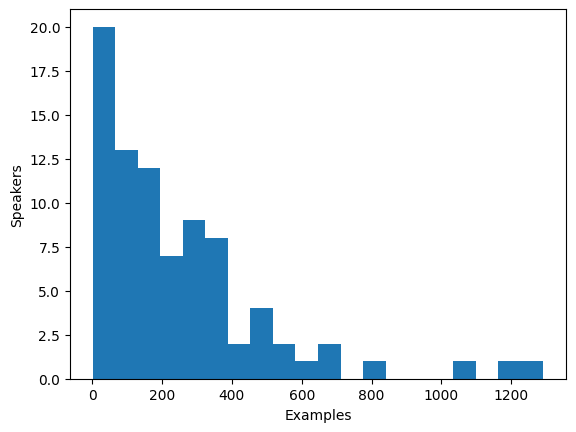

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Histogram, veri kümesindeki konuşmacıların yaklaşık üçte birinin 100'den az örneğe sahip olduğunu, yaklaşık on konuşmacının ise 500'den fazla örneğe sahip olduğunu ortaya koymaktadır. Eğitim verimliliğini artırmak ve veri kümesini dengelemek için verileri 100 ila 400 örneğe sahip konuşmacılarla sınırlayabiliriz.

In [14]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [15]:
len(set(dataset["speaker_id"]))

42

## Speaker embeddings

TTS modelinin birden fazla konuşmacı arasında ayrım yapmasını sağlamak için her örnek için bir konuşmacı katıştırması oluşturmanız gerekir. Konuşmacı katıştırması, belirli bir konuşmacının ses özelliklerini yakalayan modele ek bir girdidir. Bu konuşmacı katıştırmalarını oluşturmak için SpeechBrain'in önceden eğitilmiş spkrec-xvect-voxceleb modelini kullanın.

Bir giriş ses dalga biçimini alan ve karşılık gelen konuşmacı katıştırmasını içeren 512 öğeli bir vektör çıktısı veren create_speaker_embedding() işlevini oluşturun.

In [16]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

speechbrain/spkrec-xvect-voxceleb modelinin VoxCeleb veri kümesindeki İngilizce konuşma üzerinde eğitildiğini, oysa bu kılavuzdaki eğitim örneklerinin Hollandaca olduğunu belirtmek önemlidir. Bu modelin Hollandaca veri kümemiz için makul konuşmacı katıştırmaları üreteceğine inanıyor olsak da, bu varsayım her durumda geçerli olmayabilir.

Optimum sonuçlar için, önce hedef konuşma üzerinde bir X-vektör modeli eğitmemiz gerekir. Bu, modelin Hollanda dilinde bulunan benzersiz ses özelliklerini daha iyi yakalayabilmesini sağlayacaktır. Kendi X-vektör modelinizi eğitmek isterseniz, bu kodu örnek olarak kullanabilirsiniz.

## Processing the dataset

In [17]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [18]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

2024-08-19 08:27:17.785607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 08:27:17.785732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 08:27:17.912969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['input_ids', 'labels', 'speaker_embeddings']

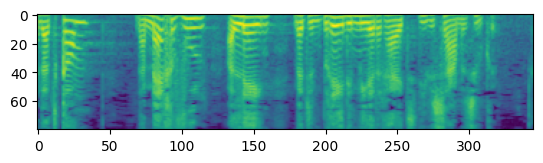

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [20]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


In [21]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

8259

In [22]:
dataset = dataset.train_test_split(test_size=0.1)

### Data collator

Birden fazla örneği bir yığın halinde birleştirmek için özel bir veri harmanlayıcı tanımlamanız gerekir. Bu harmanlayıcı, daha kısa dizileri dolgu belirteçleriyle doldurarak tüm örneklerin aynı uzunlukta olmasını sağlar. Spektrogram etiketleri için, dolgulu kısımlar -100 özel değeri ile değiştirilir. Bu özel değer, modele spektrogram kaybını hesaplarken spektrogramın o kısmını göz ardı etmesi talimatını verir.

In [23]:
from dataclasses import dataclass
from typing import Any

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any
    
    def __call__(self, features):
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]
        
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )
        
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )
        
        del batch["decoder_attention_mask"]
        
        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

SpeechT5'te, modelin kod çözücü kısmına girdi 2 kat azaltılır. Başka bir deyişle, hedef dizideki diğer her zaman adımını atar. Kod çözücü daha sonra iki kat daha uzun bir dizi tahmin eder. Orijinal hedef dizinin uzunluğu tek olabileceğinden, veri harmanlayıcı, dizinin maksimum uzunluğunu 2'nin katı olacak şekilde yuvarladığından emin olur.

In [24]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [25]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [26]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

Eğitim argümanlarını tanımlayın. Burada eğitim süreci sırasında herhangi bir değerlendirme ölçütü hesaplamıyoruz, değerlendirme hakkında bu bölümün ilerleyen kısımlarında konuşacağız. Bunun yerine, sadece kayba bakacağız:

In [27]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


- gradient_accumulation_steps: Gradienlerin (eğimlerin) hesaplanma sıklığını belirler. Örneğin, bu değer 8 ise, her 8 adımda bir gradyanlar biriktirilir ve ardından geri yayılım (backpropagation) yapılır. Bu yöntem, daha küçük bir batch boyutuyla daha büyük bir batch boyutunu simüle etmeye yardımcı olur.

- warmup_steps: Öğrenme hızının kademeli olarak artacağı adım sayısı. Bu adımlar boyunca öğrenme hızı sıfırdan başlar ve belirlenen öğrenme hızına ulaşır.

In [28]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [29]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.518600,0.479786
2000,0.496500,0.466607
3000,0.492300,0.461252
4000,0.491300,0.461397


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/opt/conda/lib/python3.10/site-packages/torch/utils/che

TrainOutput(global_step=4000, training_loss=0.5227093529701233, metrics={'train_runtime': 10256.839, 'train_samples_per_second': 12.479, 'train_steps_per_second': 0.39, 'total_flos': 1.6957759754985984e+16, 'train_loss': 0.5227093529701233, 'epoch': 17.21355567509414})

In [30]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


CommitInfo(commit_url='https://huggingface.co/Leotrim/speecht5_finetuned_voxpopuli_nl/commit/e54979b903696ae9833149295cded02627847ae4', commit_message='End of training', commit_description='', oid='e54979b903696ae9833149295cded02627847ae4', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [31]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "Leotrim/speecht5_finetuned_voxpopuli_nl"
)

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [32]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [33]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

In [34]:
inputs = processor(text=text, return_tensors="pt")

Instantiate a vocoder and generate speech:

In [35]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [38]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

# Evaluating text-to-speech models

Eğitim süresi boyunca, metinden konuşmaya modeller tahmin edilen spektrogram değerleri ile üretilenler arasındaki ortalama kare hata kaybını (veya ortalama mutlak hatayı) optimize eder. Hem MSE hem de MAE, modeli tahmin edilen ve hedef spektrogramlar arasındaki farkı en aza indirmeye teşvik eder. Bununla birlikte, TTS one-to-many eşleme problemi olduğundan, yani belirli bir metin için çıktı spektrogramı birçok farklı şekilde temsil edilebildiğinden, ortaya çıkan metinden konuşmaya (TTS) modellerinin değerlendirilmesi çok daha zordur.

Doğruluk veya kesinlik gibi nicel ölçütler kullanılarak nesnel olarak ölçülebilen diğer birçok hesaplama görevinin aksine, TTS'nin değerlendirilmesi büyük ölçüde öznel insan analizine dayanır.

TTS sistemleri için en yaygın kullanılan değerlendirme yöntemlerinden biri, ortalama görüş puanlarını (MOS) kullanarak nitel değerlendirmeler yapmaktır. MOS, insan değerlendiricilerin sentezlenmiş konuşmanın algılanan kalitesini 1'den 5'e kadar bir ölçekte derecelendirmesine olanak tanıyan öznel bir puanlama sistemidir. Bu puanlar genellikle insan katılımcıların sentezlenmiş konuşma örneklerini dinlediği ve derecelendirdiği dinleme testleri yoluyla toplanır.

TTS değerlendirmesi için objektif metriklerin geliştirilmesinin zor olmasının ana nedenlerinden biri, konuşma algısının öznel doğasıdır. İnsan dinleyicilerin telaffuz, tonlama, doğallık ve netlik gibi konuşmanın çeşitli yönlerine karşı farklı tercihleri ve hassasiyetleri vardır. Bu algısal nüansları tek bir sayısal değerle yakalamak göz korkutucu bir görevdir. Aynı zamanda, insan değerlendirmesinin öznelliği, farklı TTS sistemlerini karşılaştırmayı ve kıyaslamayı zorlaştırır.

Ayrıca, bu tür bir değerlendirme konuşma sentezinin doğallık, ifade gücü ve duygusal etki gibi bazı önemli yönlerini gözden kaçırabilir. Bu niteliklerin nesnel olarak ölçülmesi zordur ancak sentezlenen konuşmanın insan benzeri nitelikler taşıması ve uygun duygusal tepkiler uyandırması gereken uygulamalarda oldukça önemlidir.

Özetle, metinden sese modellerini değerlendirmek, gerçekten nesnel bir ölçütün olmaması nedeniyle karmaşık bir görevdir. En yaygın değerlendirme yöntemi olan ortalama görüş puanları (MOS), öznel insan analizine dayanır. MOS, sentezlenen konuşmanın kalitesine ilişkin değerli içgörüler sağlarken, değişkenlik ve öznelliği de beraberinde getirir.